# Fourier Transform-based models

The custom class FourierWave from `fourierwave.py` used here encapsulates several attributes and methods for applying a Fourier Transform to a time series, visualizing its main frequencies, fitting a combination of cosine waves for selected frequencies, and generating a forecast with it. It requires as input and returns as output pandas series with PeriodIndex.

The Fourier Transform is a technique originating from signal processing. In time series analysis, a Fourier Transform basically "fits" a combination of sine waves to a time series. Fourier Transforms are therefore well suited to model relatively smooth curves resembling sine waves. 

### References:

* https://docs.scipy.org/doc/numpy/reference/routines.fft.html

### TO DO:

* Update FourierWave class to accept hourly and weekly data as well

## Imports

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from forecasttk.lineartrend import LinearTrend
from forecasttk.fourierwave import FourierWave
import forecasttk.visualize as viz
from forecasttk.evaluate import eval_model 

plt.style.use("seaborn-whitegrid")

## With monthly data

### Load and prepare data

In [18]:
# Load data
df = pd.read_csv("data/catalog_seasfac.csv",
                 usecols=["date", "men", "women", "jewel", "mail", "page", "phone", "print", "service"],
                 index_col = "date")

# Convert index to PeriodIndex
df.index = pd.to_datetime(df.index).to_period("M")

# Define features and target
y = df["women"]
X = df[["mail", "page", "phone", "print", "service"]]

# Show features and target
X.join(y).head()

,mail,page,phone,print,service,women
date,,,,,,
1989-01,7978,73,34,22294.48,20,16578.93
1989-02,8290,88,29,27426.47,20,18236.13
1989-03,8029,65,24,27978.66,26,43393.55
1989-04,7752,85,20,28949.65,22,30908.49
1989-05,8685,74,17,22642.27,21,28701.58


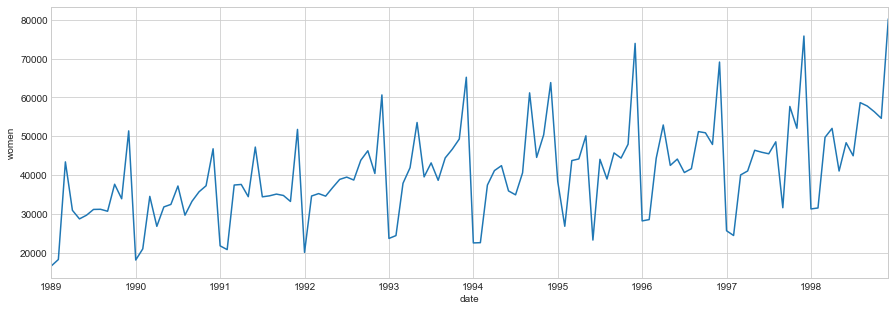

In [19]:
# Visualize target
viz.plot_series(y, xlabel=y.index.name, ylabel=y.name)

### Train/test split

In [20]:
y_train = y[:"1997"]
y_test = y["1998"]

### De-trend time series

>> TRAINING DATA
Mean of true values:          39477.2528
Mean of predicted values:     39477.2528
Mean absolute error:          7071.6805
Mean relative error:          0.1791
Root mean squared error:      10189.6540
Coefficient of determination: 0.2248
>> TEST DATA
Mean of true values:          50541.5242
Mean of predicted values:     50038.5851
Mean absolute error:          9012.3258
Mean relative error:          0.1783
Root mean squared error:      12137.2745
Coefficient of determination: 0.0762


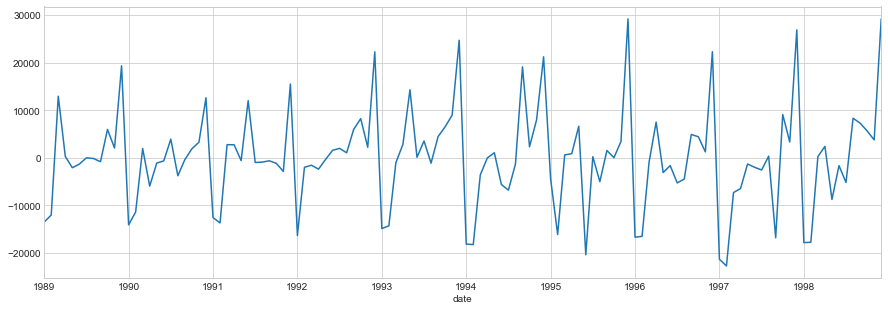

In [21]:
# Instantiante and train model
trend_model = LinearTrend(y=y_train)
trend_model.fit_ts()

# Predict and forecast
y_pred = trend_model.predict_ts()
y_fcst = trend_model.forecast_ts(steps=12)
y_trend = y_pred.append(y_fcst)

# Generate de-trended time series
y_detrended = y - y_trend

# Evaluate model on training set
print(">> TRAINING DATA")
eval_model(y_train, y_pred)

# Evaluate model on test set
print(">> TEST DATA")
eval_model(y_test, y_fcst)

# Visualize de-trended time series (=residuals)
viz.plot_series(y_detrended, xlabel=y_detrended.index.name, ylabel=y_detrended.name)

### Fourier Transform

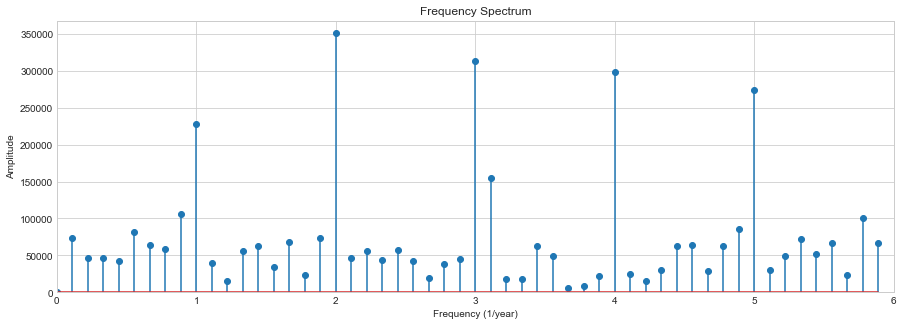

In [22]:
# Instantiate FourierWave class
wave_model = FourierWave(y=y_detrended[y_train.index], freq="M")

# Apply Fourier Transform
wave_model.transform()

# Visualize frequency domain spectrum
wave_model.plot_spectrum()

In [23]:
# Select frequencies for the Transform
frequency_indices = [9, 18]

# Fit model
wave_model.fit(frequency_indices=frequency_indices)

# Show (frequency, amplitude, angle) tuples used to fit the model
for tpl in (wave_model.freq_amp_angle_ls):
    print("Frequency: {:.4f} | Amplitude: {:.2f} | Angle: {:.2f}".format(tpl[0], tpl[1], tpl[2]))

Frequency: 0.0833 | Amplitude: 228609.71 | Angle: 1.74
Frequency: 0.1667 | Amplitude: 350691.38 | Angle: 2.14


>> TRAINING DATA
Mean of true values:          39477.2528
Mean of predicted values:     -0.0000
Mean absolute error:          39477.2528
Mean relative error:          1.0000
Root mean squared error:      40708.6897
Coefficient of determination: -11.3724
>> TEST DATA
Mean of true values:          50541.5242
Mean of predicted values:     0.0000
Mean absolute error:          50541.5242
Mean relative error:          1.0000
Root mean squared error:      51685.5255
Coefficient of determination: -15.7515


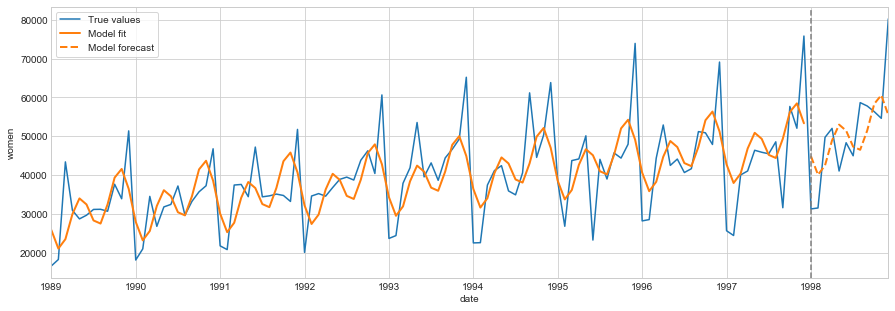

In [24]:
# Predict and forecast
y_pred = wave_model.predict()
y_fcst = wave_model.forecast(steps=12)

# Add wave to trend
y_trend_wave = y_trend + y_pred.append(y_fcst)

# Evaluate model on training set
print(">> TRAINING DATA")
eval_model(y_train, y_pred)

# Evaluate model on test set
print(">> TEST DATA")
eval_model(y_test, y_fcst)

# Visualize model performance
viz.plot_model(y, y_trend_wave[y_train.index], y_trend_wave[y_test.index],
               xlabel=y.index.name, ylabel=y.name)

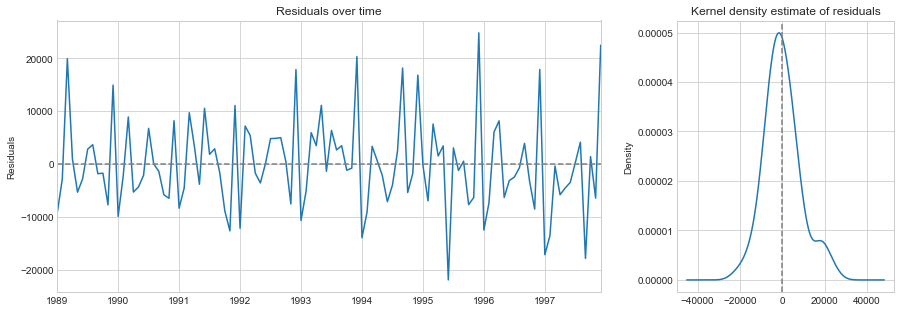

In [26]:
# Plot residual errors
residuals = y[y_train.index] - y_trend_wave[y_train.index]
viz.plot_residuals(residuals=residuals)

## With daily data

### Load and prepare data

In [27]:
# Load data
y = pd.read_csv("data/daily-min-temperatures.csv", index_col="Date")
y = y["Temp"]

# Convert index to PeriodIndex
y.index = pd.to_datetime(y.index).to_period("D")

y.head()

Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Freq: D, Name: Temp, dtype: float64

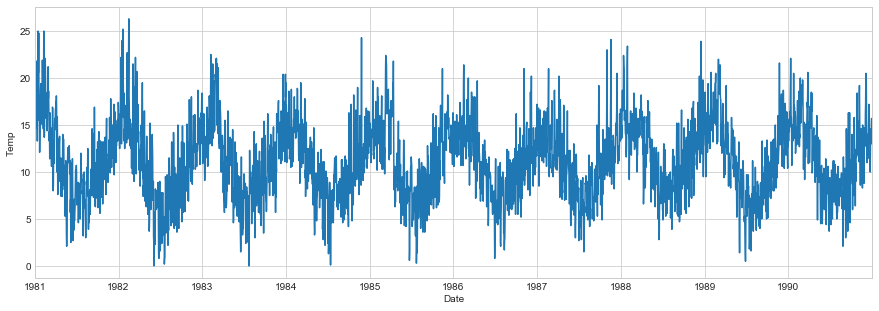

In [28]:
# Visualize target
viz.plot_series(y, xlabel=y.index.name, ylabel=y.name)

### Train/test split

In [29]:
y_train = y[:"1989"]
y_test = y["1990"]

### Fourier Transform

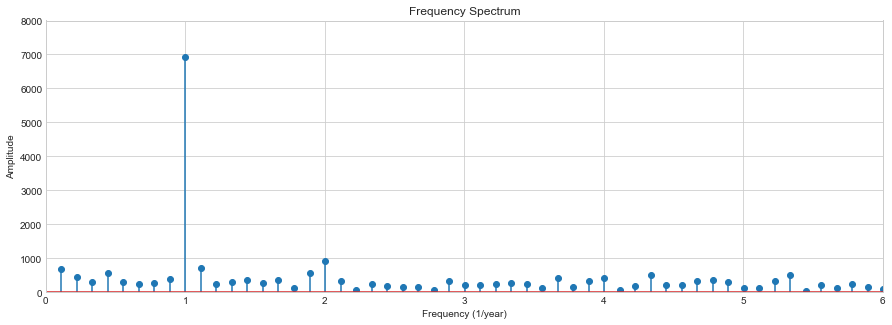

In [30]:
# Instantiate FourierWave class
wave_model = FourierWave(y=y_train, freq="D")

# Apply Fourier Transform
wave_model.transform()

# Visualize frequency domain spectrum
wave_model.plot_spectrum(max_magnitude=8000)

In [31]:
# Select frequencies for the Transform
frequency_indices = [9, 18]

# Fit model
wave_model.fit(frequency_indices=frequency_indices)

# Show stored (frequency, amplitude, angle) tuples
for tpl in (wave_model.freq_amp_angle_ls):
    print("Frequency: {:.4f} | Amplitude: {:.2f} | Angle: {:.2f}".format(tpl[0], tpl[1], tpl[2]))

Frequency: 0.0027 | Amplitude: 6932.40 | Angle: -0.43
Frequency: 0.0055 | Amplitude: 934.34 | Angle: -2.42


>> TRAINING DATA
Mean of true values:          11.1231
Mean of predicted values:     0.0024
Mean absolute error:          11.1208
Mean relative error:          0.9998
Root mean squared error:      11.4609
Coefficient of determination: -6.8490
>> TEST DATA
Mean of true values:          11.6696
Mean of predicted values:     0.0024
Mean absolute error:          11.6672
Mean relative error:          0.9998
Root mean squared error:      11.9299
Coefficient of determination: -8.5704


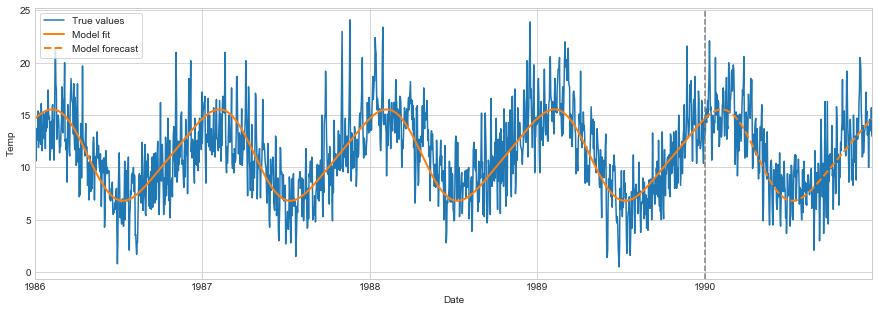

In [32]:
# Predict and forecast
y_pred = wave_model.predict()
y_fcst = wave_model.forecast(steps=365)

# Add mean to wave
y_wave = (y_pred.append(y_fcst) + y.mean()).rename("Fourier Wave + Mean")

# Evaluate model on training set
print(">> TRAINING DATA")
eval_model(y_train, y_pred)

# Evaluate model on test set
print(">> TEST DATA")
eval_model(y_test, y_fcst)

# Visualize model performance
viz.plot_model(y["1986":], y_wave["1986":"1989"], y_wave["1990"], xlabel=y.index.name, ylabel=y.name)

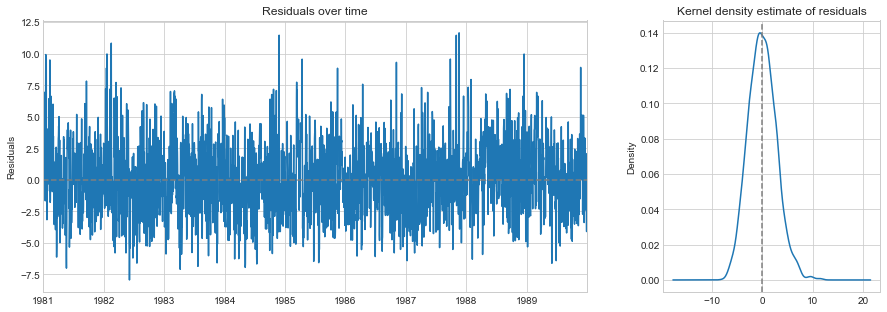

In [34]:
# De-mean series using the mean of the training data to center the series around 0 for checking residuals
residuals = (y_train - y_pred) - y_train.mean()

# Plot residual errors
viz.plot_residuals(residuals)